In [3]:
import pandas as pd
from scipy import stats as st
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 2

In [4]:
#calls.info()
#internet.info()
#messages.info()
#tariffs.info()
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Для работы с данными не требуется менять типа данных. Так же, по поводу звонков, которые длятся 0.0 минут их нужно удалить, так как за них не взимается плата и для анализа и расчета они не понадобятся. В теории звонки либо были отклонены, либо были сброшены, поэтому мы видим нулевое значение

In [5]:
import numpy as np
calls['duration'] = calls['duration'].apply(np.ceil)
calls = calls[calls['duration'] != 0]
calls

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499
202603,1499_216,2018-10-18,19.0,1499
202604,1499_217,2018-11-10,11.0,1499
202605,1499_218,2018-10-06,5.0,1499


Округлили минуты вверх, так как было сказанно, что Мегалайн округляет все значения вверх. Удалили нулевые значения, для расчета выручки и другого анализа данные строчки не нужны.

In [6]:
calls['call_date'] = pd.DatetimeIndex(calls['call_date'])
calls['month'] = calls['call_date'].dt.month
messages['message_date'] = pd.DatetimeIndex(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
internet['session_date'] = pd.DatetimeIndex(internet['session_date'])
internet['month'] = internet['session_date'].dt.month

Добавил столбцы с месяцами

In [7]:
num_of_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum'])
num_of_messages = messages.groupby(['user_id', 'month'])['id'].count()
num_of_internet = internet.groupby(['user_id', 'month']).sum()['mb_used']

In [8]:
df_event_numbers = pd.concat([num_of_calls, num_of_messages, num_of_internet], axis=1)
df_event_numbers = df_event_numbers.reset_index()
df_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id    3214 non-null int64
month      3214 non-null int64
count      3168 non-null float64
sum        3168 non-null float64
id         2717 non-null float64
mb_used    3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


In [9]:
df_final = pd.merge(df_event_numbers, users.loc[:, ['tariff', 'city', 'age',
                                                  'reg_date', 'user_id']],
                  on='user_id')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 10 columns):
user_id     3214 non-null int64
month       3214 non-null int64
count       3168 non-null float64
sum         3168 non-null float64
id          2717 non-null float64
mb_used     3203 non-null float64
tariff      3214 non-null object
city        3214 non-null object
age         3214 non-null int64
reg_date    3214 non-null object
dtypes: float64(4), int64(3), object(3)
memory usage: 276.2+ KB


In [10]:
def minutes_rub(raw):
    if raw['tariff'] == 'smart':
        if raw['sum'] - 500 > 0:
            return (raw['sum'] - 500) * 3
        return 0
    else:
        if raw['sum'] - 3000 > 0:
            return (raw['sum'] - 3000) * 1
        return 0
    
def sms_rub(raw):
    if raw['tariff'] == 'smart':
        if raw['id'] - 50 > 0:
            return (raw['id'] - 50) * 3
        return 0
    else:
        if raw['id'] - 1000 > 0:
            return (raw['id'] - 1000) * 1
        return 0
                        
def internet_rub(raw):
    if raw['tariff'] == 'smart':
        if raw['mb_used'] / 1024 - 15 > 0:
            return (raw['mb_used'] / 1024 - 15) * 200
        return 0
    else:
        if raw['mb_used'] / 1024 - 30 >0:
            return(raw['mb_used'] / 1024 - 30) * 150
        return 0
    
def tariff_rub(raw):
    if raw['tariff'] == 'smart':
        return 550
    return 1950

df_final['minutes_payment'] = df_final.apply(minutes_rub, axis=1)
df_final['sms_payment'] = df_final.apply(sms_rub, axis=1)
df_final['internet_payment'] = df_final.apply(internet_rub, axis=1)
df_final['tariff_payment'] = df_final.apply(tariff_rub, axis=1)
df_final['all_payment'] = (df_final['minutes_payment'] +
                           df_final['sms_payment'] +
                           df_final['internet_payment'] +
                           df_final['tariff_payment']
                          )
df_final.columns = ['id_пользователя', 'Месяц', 'Звонки, шт', 'Звонки, мин', 'Cмс, шт',
                    'Интернет, мБ', 'Тариф', 'Город', 'Возраст', 'Дата регистрации', 'Минуты сверх, руб',
                    'Смс сверх, руб', 'Интернет сверх, руб', 'Тарифный платеж', 'Общая сумма платежа за месяц'
                   ]
df_final.describe()                       

,id_пользователя,Месяц,"Звонки, шт","Звонки, мин","Cмс, шт","Интернет, мБ",Возраст,"Минуты сверх, руб","Смс сверх, руб","Интернет сверх, руб",Тарифный платеж,Общая сумма платежа за месяц
count,3214.000000,3214.000000,3168.000000,3168.000000,2717.000000,3203.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,8.317362,51.450126,457.797033,45.283769,17266.708626,46.641568,86.564095,12.067206,406.946444,979.060361,1484.638106
std,144.659172,2.905413,26.439188,237.423514,35.051363,7516.356902,16.586109,219.231515,34.526748,647.482348,645.539596,782.900076
min,1000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,550.000000,550.000000
25%,1125.000000,6.000000,33.000000,290.750000,19.000000,12526.905000,32.000000,0.000000,0.000000,0.000000,550.000000,691.885742
50%,1253.000000,9.000000,50.000000,447.500000,38.000000,16963.110000,46.000000,0.000000,0.000000,0.000000,550.000000,1557.608398
75%,1378.750000,11.000000,67.000000,592.250000,63.000000,21432.175000,62.000000,0.000000,0.000000,679.962402,1950.000000,1950.000000
max,1499.000000,12.000000,190.000000,1673.000000,224.000000,49745.690000,75.000000,2805.000000,279.000000,4529.775391,1950.000000,6699.775391


In [11]:
df_final['Интернет, гБ'] = df_final['Интернет, мБ'] / 1024
df_final = df_final.round(2)
df_final

,id_пользователя,Месяц,"Звонки, шт","Звонки, мин","Cмс, шт","Интернет, мБ",Тариф,Город,Возраст,Дата регистрации,"Минуты сверх, руб","Смс сверх, руб","Интернет сверх, руб",Тарифный платеж,Общая сумма платежа за месяц,"Интернет, гБ"
0,1000,5,17.0,159.0,22.0,2253.49,ultra,Краснодар,52,2018-05-25,0.0,0.0,0.00,1950,1950.00,2.20
1,1000,6,28.0,172.0,60.0,23233.77,ultra,Краснодар,52,2018-05-25,0.0,0.0,0.00,1950,1950.00,22.69
2,1000,7,41.0,340.0,75.0,14003.64,ultra,Краснодар,52,2018-05-25,0.0,0.0,0.00,1950,1950.00,13.68
3,1000,8,42.0,408.0,81.0,14055.93,ultra,Краснодар,52,2018-05-25,0.0,0.0,0.00,1950,1950.00,13.73
4,1000,9,46.0,466.0,57.0,14568.91,ultra,Краснодар,52,2018-05-25,0.0,0.0,0.00,1950,1950.00,14.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20579.36,smart,Владикавказ,68,2018-07-19,0.0,0.0,1019.41,550,1569.41,20.10
3210,1499,9,8.0,70.0,11.0,1845.75,smart,Пермь,35,2018-09-27,0.0,0.0,0.00,550,550.00,1.80
3211,1499,10,44.0,449.0,48.0,17788.51,smart,Пермь,35,2018-09-27,0.0,0.0,474.32,550,1024.32,17.37
3212,1499,11,62.0,612.0,59.0,17963.31,smart,Пермь,35,2018-09-27,336.0,27.0,508.46,550,1421.46,17.54


## Шаг 3

In [12]:
ax=df_final.plot(x='Месяц', y='Звонки, шт', style='o', xlim=(0,13), ylim=(0,195), figsize=(10,4))
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во звонков')

Text(0, 0.5, 'Кол-во звонков')

Самая низкая активность звонков в январе  и самая высокая в декабре, так же больше всего звонков в декабре и меньше всего в январе. На фоне праздников такая разница. Так же в основном большая активность кол-ва звонков наблюдается начиная с августа месяца. Проверим выводы ниже

In [13]:
month_tariff_stat = df_final.pivot_table(index=['Месяц', 'Тариф'],
                    values = ['Звонки, мин','Cмс, шт', 'Интернет, мБ', 'Интернет, гБ' ],
                    aggfunc='mean')
month_tariff_stat = month_tariff_stat.round(2)
month_tariff_stat

Cмс, шт  Звонки, мин  Интернет, гБ  Интернет, мБ
Месяц Тариф                                                  
1     smart    20.00       210.03          8.31       8513.72
      ultra    43.43       428.11         12.83      13140.68
2     smart    27.94       298.69         11.33      11597.05
      ultra    32.94       310.04         12.55      12846.48
3     smart    35.55       390.05         14.75      15104.16
      ultra    47.80       489.65         17.12      17535.55
4     smart    35.86       370.44         13.15      13462.18
      ultra    44.51       475.30         16.43      16828.13
5     smart    39.03       387.36         15.43      15805.18
      ultra    48.77       534.25         19.20      19656.53
6     smart    38.58       398.07         15.42      15794.65
      ultra    52.31       497.47         18.70      19152.95
7     smart    38.99       408.35         15.37      15743.15
      ultra    62.14       570.89         20.24      20723.39
8     smart    38.75       423.27         16.29      16681.71
      ultra    58.90       535.81         19.30      19760.73
9     smart    39.22       430.27         15.92      16303.58
      ultra    63.29       563.96         18.92      19372.74
10    smart    39.08       427.59         16.36      16757.12
      ultra    69.78       581.73         19.74      20209.64
11    smart    39.88       436.65         16.50      16895.70
      ultra    66.16       562.36         19.47      19935.59
12    smart    42.26       479.99         17.69      18113.66
      ultra    72.01       614.93         21.44      21951.09

Наблюдается стабильный рост числа звонков, потраченных минут и интернет трафика с 1 по 12 месяц. У тарифа Смарт показатели выше в первом месяце около 50 процентов разница, к 12 месяцу разница уменьшается (около 30%).

In [14]:
df_final.groupby(['Тариф'])['Звонки, мин'].mean()

Тариф
smart    419.440342
ultra    547.755016
Name: Звонки, мин, dtype: float64

Тариф
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Звонки, мин, dtype: object

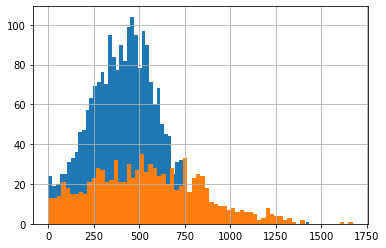

In [15]:
df_final.groupby(['Тариф'])['Звонки, мин'].hist(bins=70)

In [16]:
calls_min_stat = df_final[df_final['Минуты сверх, руб'] != 0]
calls_min_stat_pivot = calls_min_stat.pivot_table(index='Тариф', values='Минуты сверх, руб',
                                                  aggfunc=['count', 'mean'])
calls_min_stat_pivot.columns = ['Кол-во пользователей превысящие минутный трафик',
                               'Средняя сумма оплачиваемая ежемесячно за первышение минутного трафика']
calls_min_stat_pivot = calls_min_stat_pivot.round(2)
calls_min_stat_pivot


,Кол-во пользователей превысящие минутный трафик,Средняя сумма оплачиваемая ежемесячно за первышение минутного трафика
Тариф,,
smart,754,368.99


#### Как мы видим пользователи тарифа Ультра не используют минуты сверх трафика.
#### Из 2229 пользователей тарифа смарт 33 процента(754 пользователя) в среднем переплаивают 369 рублей за минуты сверх тарифа

In [17]:
sms_stat = df_final[df_final['Смс сверх, руб'] != 0]

sms_stat_pivot = sms_stat.pivot_table(index='Тариф', values='Смс сверх, руб',
                                                  aggfunc=['count', 'mean'])
sms_stat_pivot.columns = ['Кол-во пользователей отправляющие смс сверх трафика',
                              'Средняя сумма оплачиваемая ежемесячно за первышение смс трафика']
sms_stat_pivot.round(2)

,Кол-во пользователей отправляющие смс сверх трафика,Средняя сумма оплачиваемая ежемесячно за первышение смс трафика
Тариф,,
smart,564,68.77


#### Как мы видим пользователи тарифа Ультра не используют минуты сверх трафика. Из 2229 пользователей тарифа смарт 25 процентов(564 пользователя) в среднем переплаивают 69 рублей за смс сверх тарифа

In [18]:
internet_stat = df_final[df_final['Интернет сверх, руб'] != 0]

internet_stat_pivot = internet_stat.pivot_table(index='Тариф', values='Интернет сверх, руб',
                                                  aggfunc=['count', 'mean'])
internet_stat_pivot.columns = ['Кол-во пользователей превышающие интернет трафика',
                              'Средняя сумма оплачиваемая ежемесячно за первышение интернет трафика']
internet_stat_pivot.round(2)
internet_stat_pivot


,Кол-во пользователей превышающие интернет трафика,Средняя сумма оплачиваемая ежемесячно за первышение интернет трафика
Тариф,,
smart,1304,920.019287
ultra,134,807.618209


####  Из 2229 пользователей тарифа Смарт 58 процентов (1304 пользователя) в среднем переплаивают 920 рублей за интернет сверх тарифа. Из 985 пользователей 13,6% (134 пользователя) Тарифа Ультра переплачивают ежемесячно в среднем 807 рублей за интернет сверх тарифа.

In [19]:
df_final.groupby('Тариф')['Общая сумма платежа за месяц'].describe() 

,count,mean,std,min,25%,50%,75%,max
Тариф,,,,,,,,
smart,2229.0,1230.442414,785.720838,550.0,550.0,957.98,1665.49,6699.78
ultra,985.0,2059.868873,354.880761,1950.0,1950.0,1950.00,1950.00,4736.97


### В итоге пользователи тарифа Смарт в средней сумме по всем услугам переплачивают ежемесячно 1355 рублей. А пользователи Тарифа Ультра переплачивают в средней сумме(только за Интернет трафик) 807 рублей. Если сплюсовать эти средние суммы со стандартным ежемесячным платежом то получает по тарифу смарт - 1905 рублей, по тарифу Ультра 2757 рублей.

In [20]:
tariff_mean = df_final.pivot_table(index='Тариф', values = ['Звонки, шт', 'Звонки, мин',
                                                          'Cмс, шт', 'Интернет, гБ'],
                                 aggfunc=['mean'])
tariff_mean = tariff_mean.round(2)
tariff_mean

mean                                    
      Cмс, шт Звонки, мин Звонки, шт Интернет, гБ
Тариф                                            
smart   38.72      419.44      47.12        15.84
ultra   61.16      547.76      61.61        19.21

Несмотря на то, что показатели у тарифа Смарт выше, у пользователей тарифа Ультра средний показатель выше

In [21]:
tariff_variance = df_final.pivot_table(index='Тариф', values = ['Звонки, шт', 'Звонки, мин',
                                                          'Cмс, шт', 'Интернет, мБ'],
                                       aggfunc='var')
tariff_variance['Интернет, гБ'] = tariff_variance['Интернет, мБ'] / 1024
tariff_variance = tariff_variance.round(2)
tariff_variance

,"Cмс, шт","Звонки, мин","Звонки, шт","Интернет, мБ","Интернет, гБ"
Тариф,,,,,
smart,717.59,35718.13,436.27,34359951.68,33554.64
ultra,2109.66,93338.43,1168.90,98864248.95,96547.12


In [22]:
tariff_standart_deviation = df_final.pivot_table(index='Тариф', values = ['Звонки, шт', 'Звонки, мин',
                                                          'Cмс, шт', 'Интернет, мБ'],
                                       aggfunc='std')
tariff_standart_deviation = tariff_standart_deviation.round(2)
tariff_standart_deviation

,"Cмс, шт","Звонки, мин","Звонки, шт","Интернет, мБ"
Тариф,,,,
smart,26.79,188.99,20.89,5861.74
ultra,45.93,305.51,34.19,9943.05


#### По моему мнению для оператора выгоднее тариф Смарт, так как у него аудитория больше и он более привлекательнее для пользователей своей низкой стандартной ежемесячной платой, но люди готовы платить сверхлимита, тем самым контролируя свои расходы, так как в основном пользователи тарифа Ультра не используют весь трафик и получается, что просто переплачивают за неиспользованный трафик, но переплачивают за сверхлимит по интернет трафику.

## Шаг 4

In [23]:
proceeds = df_final.pivot_table(index='Тариф', values='Общая сумма платежа за месяц',
                               aggfunc=['sum', 'mean'])
proceeds = proceeds.round(2)
proceeds.columns = ['Общая сумма платежа по тарифам за год',
                    'Средняя сумма платежа по тарифам за год']
proceeds

,Общая сумма платежа по тарифам за год,Средняя сумма платежа по тарифам за год
Тариф,,
smart,2742656.14,1230.44
ultra,2028970.84,2059.87


Достаточно большая разница между средними платежами за месяц по тарифам, у тарифа Ультра это значения больше на 40%. Но эта сумма лишь незначительно превышаем стандартные ежемесячный платеж в 1950 рублей, в то же время у пользователей тарифа ультра, средний платеж превышает стандартный платеж на 55%. Это говорит о том, что пользователям тарифа смарт, выгоднее подобрать для себя другой тариф, это позволит сэкономить на сверхлимитном использовании услуг внетарифа, так как обычно ставки на улсуги внетраифа в разы выше.
Проверим эту гипотезу

In [24]:
revenue_smart = df_final.loc[df_final['Тариф'] == 'smart'].pivot_table(
                index='Месяц',values='Общая сумма платежа за месяц',
                aggfunc='mean')
revenue_smart_final = revenue_smart['Общая сумма платежа за месяц']
revenue_smart_final

revenue_ultra = df_final.loc[df_final['Тариф'] == 'ultra'].pivot_table(
                index='Месяц',values='Общая сумма платежа за месяц',
                aggfunc='mean')
revenue_ultra_final = revenue_ultra['Общая сумма платежа за месяц']


In [25]:
alpha = .05
results = st.ttest_ind(revenue_smart_final, revenue_ultra_final)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7648939298285596e-12
Отвергаем нулевую гипотезу


Исходя из значения р значимость различияи средних двух датасетов значительна. И поэтому гипотеза, что средняя выручка двух Тарифов различается.

In [26]:
proceeds_moscow_mean = df_final.loc[df_final['Город'] == 'Москва'].pivot_table(index='Город', values='Общая сумма платежа за месяц',
                               aggfunc=['sum', 'mean'])
proceeds_moscow_mean

,sum,mean
,Общая сумма платежа за месяц,Общая сумма платежа за месяц
Город,,
Москва,919703.2,1505.242553


In [27]:
proceeds_other_mean = df_final.loc[df_final['Город'] != 'Москва'].pivot_table(index='Город', values='Общая сумма платежа за месяц',
                               aggfunc=['sum', 'mean'])
proceeds_other_mean.columns = ['Общая сумма платежа за год', 'Общая средняя сумма платежа за год']
proceeds_other_mean['Общая средняя сумма платежа за год'].sum()


109994.40325334127

In [28]:
moscow_revenue_1 = df_final.loc[df_final['Город'] == 'Москва'].pivot_table(
                 index='Месяц', values='Общая сумма платежа за месяц', aggfunc='mean')
moscow_revenue = moscow_revenue_1['Общая сумма платежа за месяц']

other_revenue_1 = df_final.loc[df_final['Город'] != 'Москва'].pivot_table(
                 index='Месяц', values='Общая сумма платежа за месяц', aggfunc='mean')
other_revenue = other_revenue_1['Общая сумма платежа за месяц']

In [29]:
alpha = .05
results = st.ttest_ind(moscow_revenue, other_revenue)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   

p-значение: 0.23560373463037582
Не получилось отвергнуть нулевую гипотезу


p-значение = 23%, говорит о том, что величина различия незначительна между двумя датасетами.

Принцип взял из урока спринта, смысл трактовался так: Если эта вероятность относительно высока — данные не дают основания отвергнуть это предположение. Если эта вероятность низка — по наблюдаемым данным можно сделать вывод, что, скорее всего, наше предположение всё-таки неверно (но не опровергнуть его и не доказать обратное).
Поэтому в случае моего анализа, средняя выручка между Тарифами различается, а вот в случаев со средней выручкой между Московой и другими регионами, то здесь гипотеза неверна.

В целом исходя из анализа для оператора выгоден тариф Ультра, так как приносит больше денег.